**Run Expense Categorization Model (SVM, Naive Bayes, Decision Tree, KNN & BERT)**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# %pip install 'accelerate>=0.26.0'
# %pip install 'accelerate>=0.26.0'

# %pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cpu
%pip install transformers




     ---------------------------------------- 0.0/44.0 kB ? eta -:--:--
     ----------------- -------------------- 20.5/44.0 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 44.0/44.0 kB 718.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   - -------------------------------------- 0.6/12.0 MB 17.6 MB/s eta 0:00:01
   ------ --------------------------------- 2.0/12.0 MB 26.0 MB/s eta 0:00:01
   ------------ --------------------------- 3.7/12.0 MB 29.4 MB/s eta 0:00:01
   ----------------- ---------------------- 5.2/12.0 MB 30.1 MB/s eta 0:00:01
   ---------------------- ----------------- 6.7/12.0 MB 32.9 MB/s eta 0:00:01
   --------------------------- ------------ 8.1/12.0 MB 32.4 MB/s eta 0:00:01
   -------------------------------- ------- 9.7/12.0 MB 32.7 MB/s eta 0:00:01
   -------------------------------------- - 11.7/12.0 MB 38.6 MB/s eta 0:00:01
   ---------------------------------------  12.0/12.0 MB 38.5 MB/s eta 0:

### Expense Categorization: 5-Model Comparison (DT, KNN, SVM, NB, BERT)

In [3]:

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,validation_curve,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import joblib
import os

### Disable Weights & Biases logging to prevent login prompt ---

In [4]:
os.environ["WANDB_DISABLED"] = "true"

os.makedirs('saved_models', exist_ok=True)

### 1. DATA PREPARATION

In [ ]:
#csv_filename = r"C:\Users\USER\Documents\GitHub\classification/receipt_dataset_6000.csv"
csv_filename = r"/Applications/XAMPP/htdocs/AI/classification/receipt_dataset_6000.csv"

# try:
    # print(f"Loading {csv_filename}...")
df = pd.read_csv(csv_filename)
    # print("✅ Data Loaded Successfully!")
# except FileNotFoundError:
#     print(f"❌ Error: {csv_filename} not found.")
#     sys.exit(1)

### Split Data
### Vectorization (Needed for all traditional ML models)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print("-" * 50)

Training samples: 4800, Testing samples: 1200
--------------------------------------------------


### 2. TRADITIONAL ML (4 Models)

In [32]:
print("Running Traditional Machine Learning Models...")
ml_results = {}

Running Traditional Machine Learning Models...


### --- A. Naive Bayes (NB) ---

In [33]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_acc = accuracy_score(y_test, nb_model.predict(X_test_tfidf))
ml_results['Naive Bayes'] = nb_acc
print(f"✅ Naive Bayes Accuracy: {nb_acc:.4f}")




✅ Naive Bayes Accuracy: 1.0000


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
/Users/lanters/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lanters/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
/Users/lanters/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20854 (\N{CJK UNIFIED IDEOGRAPH-5176}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fig

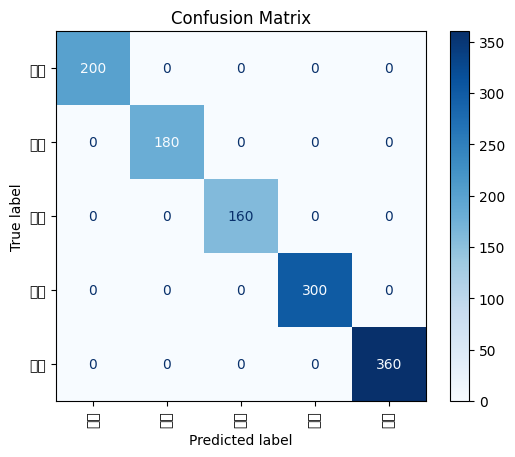

In [42]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 

plt.rcParams['axes.unicode_minus'] = False

y_pred = nb_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [43]:
print(classification_report(y_test, y_pred, target_names=nb_model.classes_))

              precision    recall  f1-score   support

          交通       1.00      1.00      1.00       200
          其他       1.00      1.00      1.00       180
          娛樂       1.00      1.00      1.00       160
          購物       1.00      1.00      1.00       300
          食飯       1.00      1.00      1.00       360

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



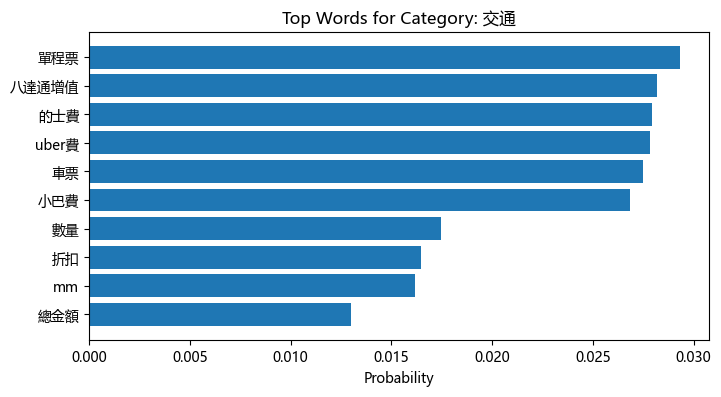

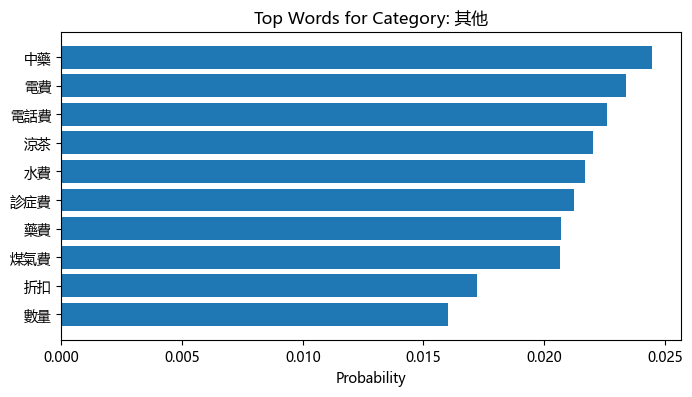

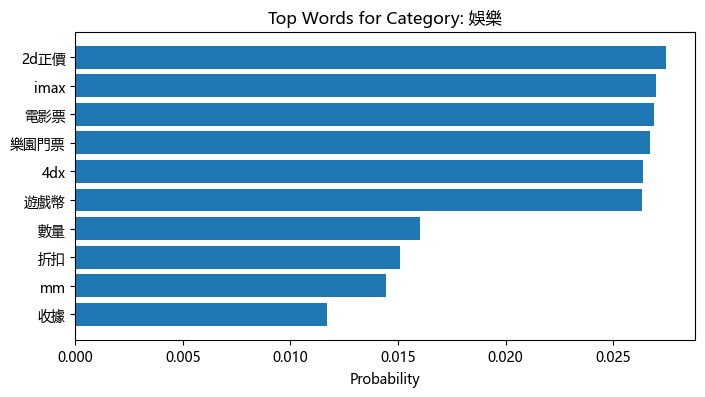

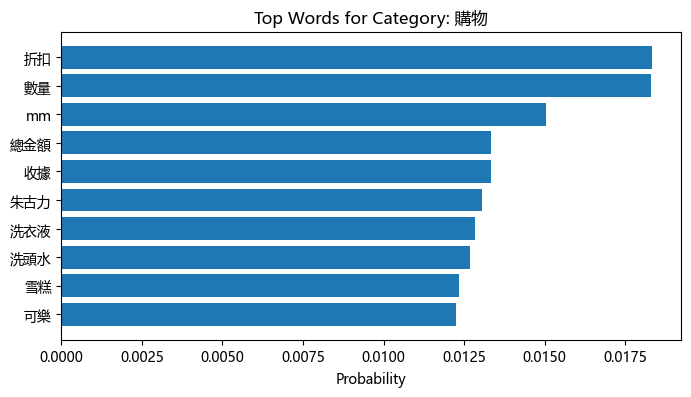

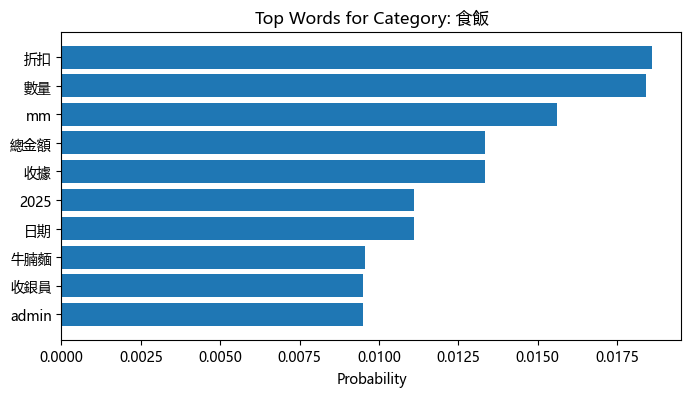

In [ ]:
feature_names = vectorizer.get_feature_names_out()
log_prob = nb_model.feature_log_prob_

for i, class_label in enumerate(nb_model.classes_):
    top10 = np.argsort(log_prob[i])[-10:]
    top_words = [feature_names[j] for j in top10]
    top_scores = log_prob[i][top10]
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_words, np.exp(top_scores))  # exp to get actual probabilities
    plt.title(f'Top Words for Category: {class_label}')
    plt.xlabel('Probability')
    plt.show()

### --- B. Support Vector Machine (SVM) ---

In [10]:
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_tfidf, y_train)
svm_acc = accuracy_score(y_test, svm_model.predict(X_test_tfidf))
# ml_results['SVM'] = svm_acc
print(f"✅ SVM Accuracy: {svm_acc:.4f}")

✅ SVM Accuracy: 1.0000


In [34]:
param_grid = {
    # 'C': [0.01, 0.1, 1, 10, 100],
    'C': [0.015],
    'kernel': ['linear']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

svm_model = grid.best_estimator_
svm_acc = accuracy_score(y_test, svm_model.predict(X_test_tfidf))
print(f"✅ SVM Test Accuracy: {svm_acc:.4f}")

ml_results['SVM'] = svm_acc

Best parameters: {'C': 0.015, 'kernel': 'linear'}
Best CV accuracy: 0.9356250000000002
✅ SVM Test Accuracy: 0.9967


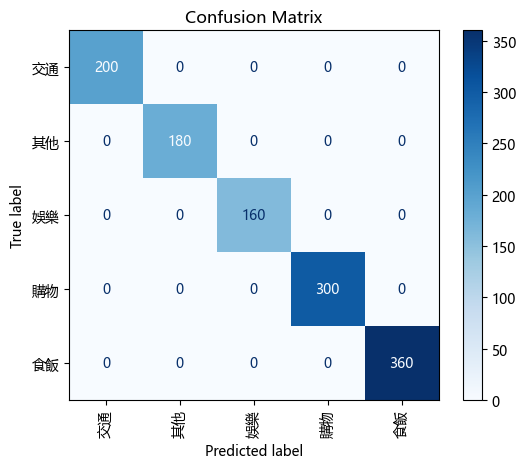

In [14]:
y_pred = svm_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

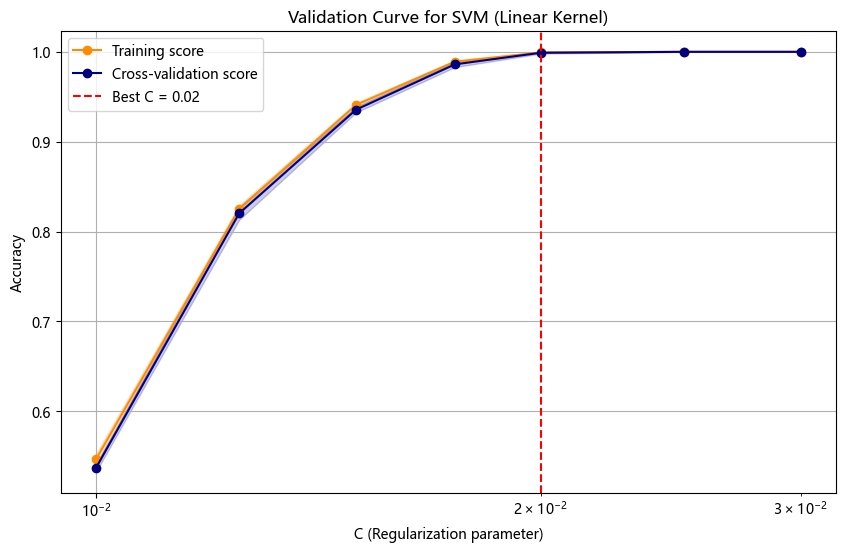

In [15]:
param_range = [0.01, 0.0125 , 0.015 , 0.0175 , 0.02 , 0.025 , 0.03]

train_scores, val_scores = validation_curve(
    SVC(kernel='linear'),            
    X_train_tfidf, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,                             
    scoring="accuracy",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")

plt.plot(param_range, val_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color="navy")

plt.xscale('log')  
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for SVM (Linear Kernel)')
best_C = grid.best_params_['C']
plt.axvline(x=best_C, color='red', linestyle='--', label=f'Best C = {best_C}')
plt.legend(loc="best")
plt.grid(True)
plt.show()

### --- C. Decision Tree (DT) ---


In [ ]:
# dt_model = DecisionTreeClassifier(random_state=42)
# dt_model.fit(X_train_tfidf, y_train)
# dt_acc = accuracy_score(y_test, dt_model.predict(X_test_tfidf))
# ml_results['Decision Tree'] = dt_acc
# print(f"✅ Decision Tree Accuracy: {dt_acc:.4f}")

✅ Decision Tree Accuracy: 0.9983


In [35]:
param_grid = {
    'max_depth': [8],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

dt_model = grid.best_estimator_
dt_acc = accuracy_score(y_test, dt_model.predict(X_test_tfidf))
ml_results['Decision Tree'] = dt_acc
print(f"✅ Decision Tree Test Accuracy: {dt_acc:.4f}")

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy: 0.7322916666666667
✅ Decision Tree Test Accuracy: 0.7225


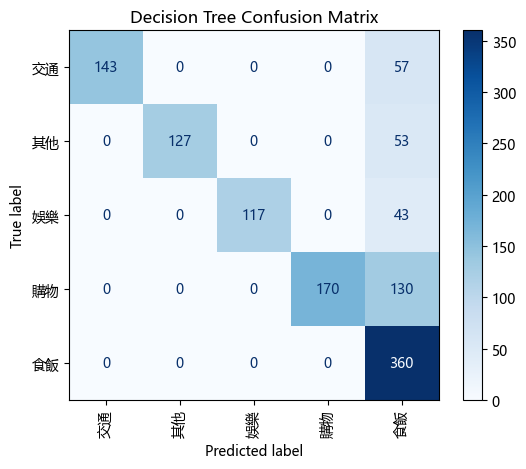

In [21]:
y_pred = dt_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=dt_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

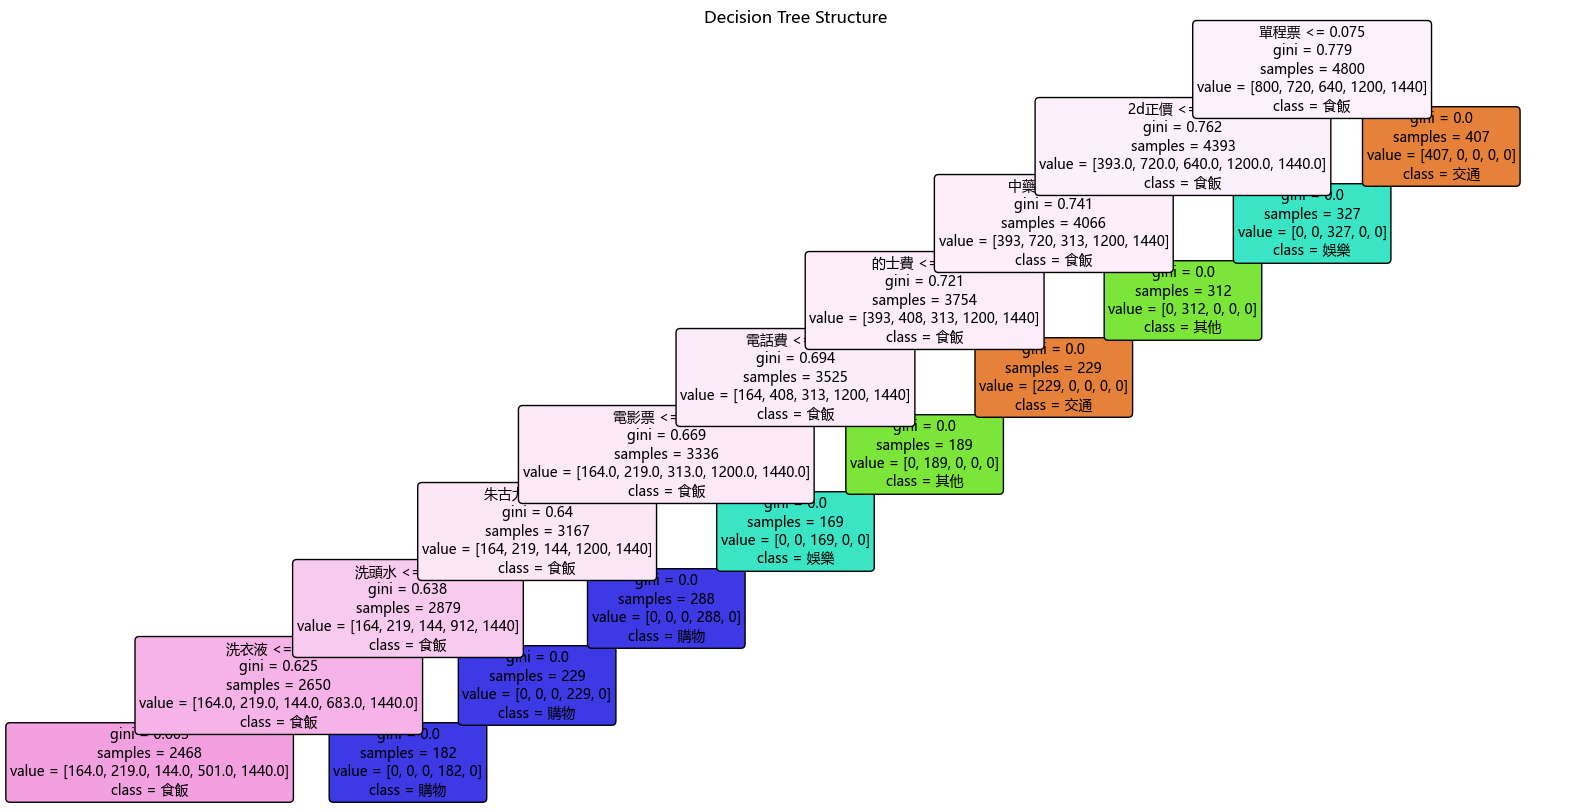

In [22]:
plt.figure(figsize=(20,10))  
plot_tree(dt_model, feature_names=vectorizer.get_feature_names_out(), 
          class_names=dt_model.classes_, filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Structure')
plt.show()

Number of points: 8
train_mean length: 8


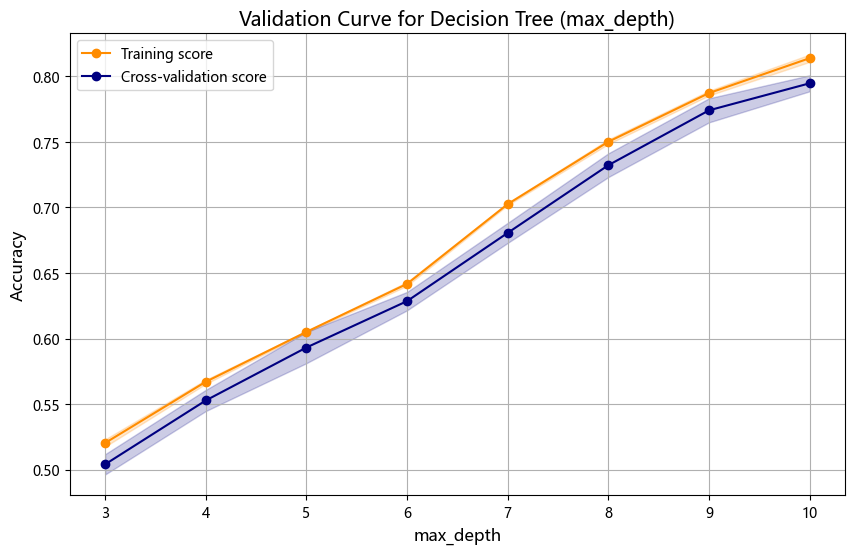

In [19]:
original_param_range = [3,4,5,6,7,8,9,10]  

plot_param_range = np.array(original_param_range)

train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train_tfidf, y_train,
    param_name="max_depth",
    param_range=original_param_range,   
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

print(f"Number of points: {len(plot_param_range)}")
print(f"train_mean length: {len(train_mean)}")

plt.figure(figsize=(10, 6))

plt.plot(plot_param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(plot_param_range, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color="darkorange")

plt.plot(plot_param_range, val_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(plot_param_range, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color="navy")

plt.title('Validation Curve for Decision Tree (max_depth)', fontsize=14)
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc="best")
plt.grid(True)

plt.xticks(plot_param_range)

plt.show()

### --- D. K-Nearest Neighbors (KNN) ---
### Using n_neighbors=3 for a simple baseline

In [36]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train_tfidf, y_train)
knn_acc = accuracy_score(y_test, knn_model.predict(X_test_tfidf))
ml_results['KNN'] = knn_acc
print(f"✅ KNN Accuracy: {knn_acc:.4f}")

print("-" * 50)

✅ KNN Accuracy: 0.9958
--------------------------------------------------


k= 1 → Accuracy: 0.9692
k= 2 → Accuracy: 0.9558
k= 3 → Accuracy: 0.9867
k= 4 → Accuracy: 0.9908
k= 5 → Accuracy: 0.9925
k= 6 → Accuracy: 0.9942
k= 7 → Accuracy: 0.9958
k= 8 → Accuracy: 0.9967
k= 9 → Accuracy: 0.9983
k=10 → Accuracy: 0.9992
k=11 → Accuracy: 0.9992
k=12 → Accuracy: 0.9992
k=13 → Accuracy: 0.9992
k=14 → Accuracy: 1.0000
k=15 → Accuracy: 1.0000
k=16 → Accuracy: 1.0000
k=17 → Accuracy: 1.0000
k=18 → Accuracy: 1.0000
k=19 → Accuracy: 1.0000
k=20 → Accuracy: 1.0000
k=21 → Accuracy: 1.0000
k=22 → Accuracy: 1.0000
k=23 → Accuracy: 1.0000
k=24 → Accuracy: 1.0000
k=25 → Accuracy: 1.0000
k=26 → Accuracy: 1.0000
k=27 → Accuracy: 1.0000
k=28 → Accuracy: 1.0000
k=29 → Accuracy: 1.0000
k=30 → Accuracy: 1.0000

🏆 Best k: 14 with Accuracy: 1.0000


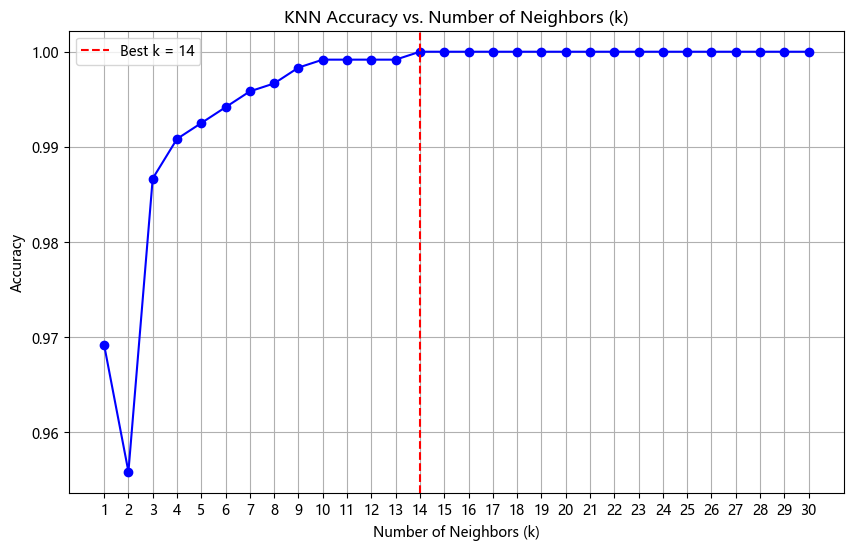

In [24]:
k_values = []
accuracies = []

for k in range(1, 31):
    k_values.append(k)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_tfidf, y_train)
    
    y_pred = knn.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    
    accuracies.append(acc)
    print(f"k={k:2d} → Accuracy: {acc:.4f}")

best_k = k_values[accuracies.index(max(accuracies))]
best_acc = max(accuracies)

print(f"\n🏆 Best k: {best_k} with Accuracy: {best_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.legend()
plt.show()

### --- E. Logistic Regression ---

In [ ]:
# logistic_model = LogisticRegression(max_iter=1000, C=5)

# logistic_model.fit(X_train_tfidf, y_train)
# logistic_acc = accuracy_score(y_test, logistic_model.predict(X_test_tfidf))
# ml_results['Logistic Regression'] = logistic_acc

# print(f"✅ Logistic Regression Accuracy: {logistic_acc:.4f}")

# print("-" * 50)


✅ Logistic Regression Accuracy: 1.0000
--------------------------------------------------


In [37]:
param_grid = {
    'C': [0.01, 0.0125 , 0.015 , 0.0175 , 0.02],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'] 
}

grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                    param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

logistic_model = grid.best_estimator_
logistic_acc = accuracy_score(y_test, logistic_model.predict(X_test_tfidf))
ml_results['Logistic Regression'] = logistic_acc
print(f"✅ Logistic Regression Test Accuracy: {logistic_acc:.4f}")

Best parameters: {'C': 0.02, 'penalty': 'l2', 'solver': 'saga'}
Best CV accuracy: 0.9572916666666667
✅ Logistic Regression Test Accuracy: 0.9908


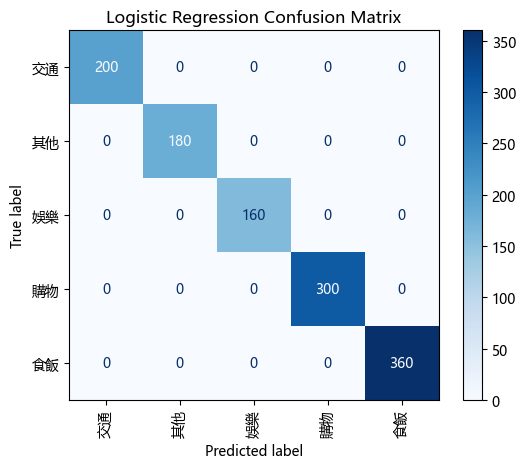

In [26]:
y_pred = logistic_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=logistic_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

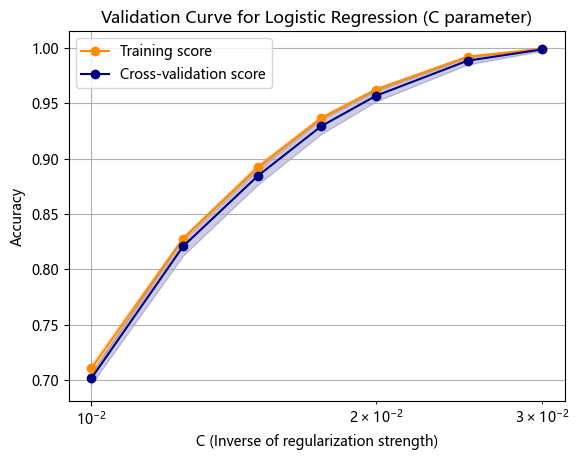

In [27]:
param_range = [0.01, 0.0125 , 0.015 , 0.0175 , 0.02 , 0.025 , 0.03]

train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=1000, solver='saga', penalty='l2'),
    X_train_tfidf, y_train, param_name="C", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std   = np.std(val_scores, axis=1)

# plt.figure(figsize=(10,6))
plt.plot(param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
plt.plot(param_range, val_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color="navy")

plt.xscale('log')
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Logistic Regression (C parameter)')
plt.legend(loc="best")
plt.grid(True)
plt.show()

### 3. DEEP LEARNING (BERT)

In [29]:
print("Initializing Deep Learning (BERT)...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)
model.to(device)

class ExpenseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# train_dataset = ExpenseDataset(X_train.tolist(), y_train.tolist(), tokenizer)
# test_dataset = ExpenseDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# training_args = TrainingArguments(
#     output_dir='./results', num_train_epochs=3, per_device_train_batch_size=8,
#     logging_dir='./logs', logging_steps=10,
#     report_to="none"
# )

# trainer = Trainer(
#     model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset,
#     compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, p.predictions.argmax(-1))}
# )

# print("Training BERT model (No Login Required)...")
# trainer.train()

# bert_eval = trainer.evaluate()
# bert_acc = bert_eval['eval_accuracy']
# ml_results['BERT'] = bert_acc
# print(f"✅ BERT Accuracy: {bert_acc:.4f}")
# print("-" * 50)


Initializing Deep Learning (BERT)...
Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### L. LLM(Bert)

Device set to use cpu


BERT Accuracy: 1.00


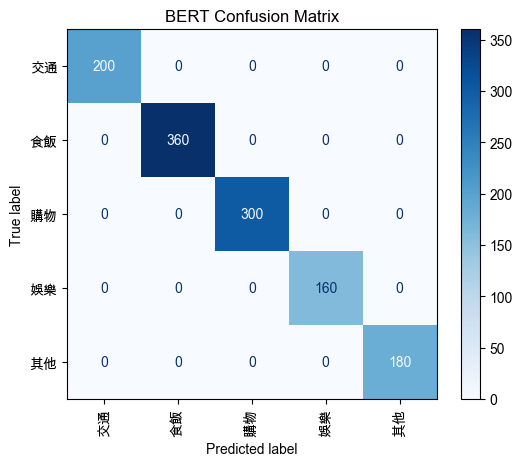

In [ ]:
import torch
from transformers import pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt

model_path = "./saved_models/fine_tuned_hk_classifier"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model folder {model_path} does not exist!")

id2label = {0: "交通", 1: "食飯", 2: "購物", 3: "娛樂", 4: "其他"}
class_names = list(id2label.values())

classifier = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path,
    device=0 if torch.cuda.is_available() else -1,
    top_k=1
)

#print("Ltest111")
#print(X_test_list)
#print(X_test)

if isinstance(X_test, pd.Series):
    X_test_list = X_test.tolist()
else:
    X_test_list = X_test

results = classifier(X_test_list)

y_pred_bert = []
for result in results:
    if isinstance(result, list) and len(result) > 0:
        inner_result = result[0]
        label = inner_result["label"]
        if label.startswith("LABEL_"):
            label_id = int(label.replace("LABEL_", ""))
            category = id2label.get(label_id, "其他")
        else:
            category = label
        y_pred_bert.append(category)
    else:
        print("Unexpected result format:", result)

bert_accuracy = accuracy_score(y_test, y_pred_bert)
print(f"BERT Accuracy: {bert_accuracy:.2f}")

ml_results['BERT'] = bert_accuracy

cm = confusion_matrix(y_test, y_pred_bert, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('BERT Confusion Matrix')
plt.show()

# ==========================================
# 4. PLOTTING COMPARISON
# ==========================================

Generating 6-Model Comparison Plot...


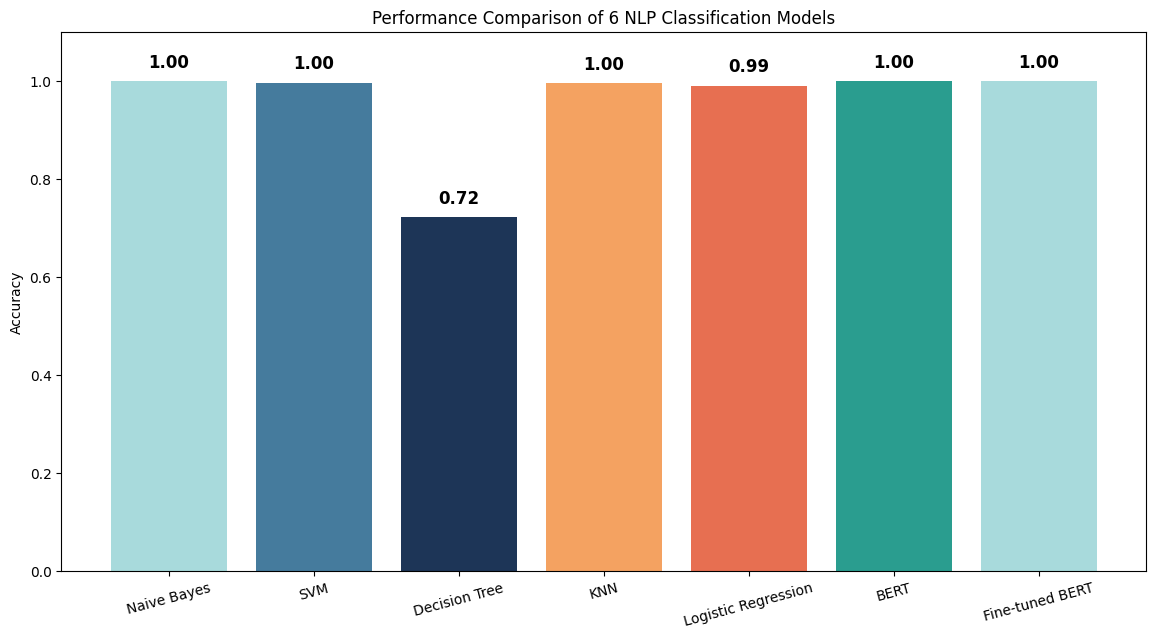

In [ ]:
print("Generating 6-Model Comparison Plot...")
models = list(ml_results.keys())
accuracies = list(ml_results.values())

plt.figure(figsize=(14, 7))
colors = ['#A8DADC', '#457B9D', '#1D3557', '#F4A261', '#E76F51', '#2A9D8F']
bars = plt.bar(models, accuracies, color=colors)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Performance Comparison of 6 NLP Classification Models')
plt.xticks(rotation=15)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}",
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# ==========================================
# 5. PREDICTION FUNCTION
# ==========================================

In [61]:

CATEGORY_MAP = {
    0: "Groceries (雜貨/超市購物)", 1: "Transportation (交通)",
    2: "Utilities (公用事業)", 3: "Entertainment (娛樂)",
    4: "Food & Drinks (食物與飲料)"
}

def predict_expense(text_input):
    """Predicts expense category using all five models."""
    global logistic_model,nb_model, svm_model, dt_model, knn_model, model, vectorizer, tokenizer, device, CATEGORY_MAP

    # --- Vectorization ---
    vec = vectorizer.transform([text_input])

    # --- ML Predictions ---
    nb_p = nb_model.predict(vec)[0]
    svm_p = svm_model.predict(vec)[0]
    dt_p = dt_model.predict(vec)[0]
    knn_p = knn_model.predict(vec)[0]
    logistic_p = logistic_model.predict(vec)[0]

    # --- DL Prediction (BERT) ---
    inputs = tokenizer(text_input, return_tensors="pt", truncation=True, padding=True, max_length=64).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    bert_p = logits.argmax().item()

    print(f"\n--- Prediction for: '{text_input}' ---")
    # print(f"**Naive Bayes:** [{nb_p}] {CATEGORY_MAP[nb_p]}")
    # print(f"**SVM:** [{svm_p}] {CATEGORY_MAP[svm_p]}")
    # print(f"**Decision Tree:** [{dt_p}] {CATEGORY_MAP[dt_p]}")
    # print(f"**KNN:** [{knn_p}] {CATEGORY_MAP[knn_p]}")
    # print(f"**BERT:** [{bert_p}] {CATEGORY_MAP[bert_p]}")

    print(f"**Naive Bayes:** [{nb_p}] ")
    print(f"**SVM:** [{svm_p}] ")
    print(f"**Decision Tree:** [{dt_p}] ")
    print(f"**KNN:** [{knn_p}] ")
    print(f"**BERT:** [{bert_p}]")
    print(f"**Logistic Regression:** [{logistic_p}]")
    
    print("-" * 40)

# print("--- Running Predictions on Test Inputs ---")
# predict_expense('Sushi and beer with friends HKD120')
# predict_expense('Uber $110.50')
# predict_expense('Electric bill')
# predict_expense('咖哩牛腩飯')
# predict_expense('米線')
# predict_expense('Concert tickets for VIP seat USD900')
# predict_expense('Socks')
# predict_expense('恐龍毛公仔')

In [131]:
# Test with Examples
import pandas as pd
import requests
from IPython.display import display
import time


API_URL = "http://127.0.0.1:8000/ai_model/GetOcrResultCategorizer"

#csv_filename = r"C:\Users\USER\Documents\GitHub\classification/test_data_cate.csv"
csv_filename = r"/Applications/XAMPP/htdocs/AI/classification/test_data_cate.csv"

df = pd.read_csv(csv_filename, encoding='utf-8')


# df = pd.read_csv(r'C:\Users\USER\Documents\GitHub\classification\Test_data_cate.csv', encoding='utf-8-sig')
df = df.head(27).reset_index(drop=True)

print(f"準備測試 {len(df)} 張圖片\n")
display(df)

results = []
model_correct = {
    "Naive Bayes": 0,
    "SVM": 0,
    "Decision Tree": 0,
    "KNN": 0,
    "Logistic Regression": 0,
    "BERT": 0
}
total = len(df)

for idx, row in df.iterrows():
    image_path = row['Path']     
    true_label = row['label']    
    
    print(f"正在處理第 {idx+1}/{total} 張: {image_path} → 真實標籤: {true_label}")
    
    try:
        with open(image_path, 'rb') as img_file:
            files = {'image': img_file}
            data = {'ocr_engine': 'easyocr'}  
            
            response = requests.post(
                API_URL,
                files=files,
                data=data,
                timeout=60
            )
        
        if response.status_code != 200:
            print(f"  API 錯誤: {response.status_code} - {response.text}")
            results.append({"image": image_path, "true": true_label, "api_error": response.text})
            continue
            
        result_json = response.json()
        
        predictions = result_json.get("predictions", {})
        total_amount = result_json.get("TotalAmount", None)
        input_text = result_json.get("input", "")[:100] + "..."  
        
        correct_models = []
        for model, pred_label in predictions.items():
            if pred_label == true_label:
                model_correct[model] += 1
                correct_models.append(model)
        
        print(f"  提取金額: {total_amount} | 正確模型: {', '.join(correct_models) or '無'}")
        
        results.append({
            "image": image_path,
            "true_label": true_label,
            "predictions": predictions,
            "TotalAmount": total_amount,
            "input_preview": input_text
        })
        
    except requests.exceptions.Timeout:
        print(f"  第 {idx+1} 張逾時（>60秒），跳過")
        results.append({"image": image_path, "true": true_label, "error": "Timeout"})
    except Exception as e:
        print(f"  錯誤: {e}")
        results.append({"image": image_path, "true": true_label, "error": str(e)})
    
    # 每張之間休息一下，避免 server 負擔過重（可選）
    time.sleep(1)








準備測試 27 張圖片



,Path,label
0,test_img/1.jpg,Food & Drinks Food & Drinks (食物與飲料)
1,test_img/2.jpg,Utilities (公用事業)
2,test_img/3.jpg,Food & Drinks (食物與飲料)
3,test_img/4.jpg,Food & Drinks (食物與飲料)
4,test_img/5.jpg,Food & Drinks (食物與飲料)
5,test_img/6.jpeg,Food & Drinks (食物與飲料)
6,test_img/7.jpeg,Food & Drinks (食物與飲料)
7,test_img/8.jpg,Groceries (雜貨/超市購物)
8,test_img/9.jpeg,Groceries (雜貨/超市購物)
9,test_img/10.jpeg,Food & Drinks (食物與飲料)


正在處理第 1/27 張: test_img/1.jpg → 真實標籤: Food & Drinks Food & Drinks (食物與飲料)
  提取金額: None | 正確模型: 無
正在處理第 2/27 張: test_img/2.jpg → 真實標籤: Utilities (公用事業)
  提取金額: 41.0 | 正確模型: BERT
正在處理第 3/27 張: test_img/3.jpg → 真實標籤: Food & Drinks (食物與飲料)
  提取金額: 0.0 | 正確模型: Naive Bayes, SVM, Decision Tree, Logistic Regression, BERT
正在處理第 4/27 張: test_img/4.jpg → 真實標籤: Food & Drinks (食物與飲料)
  提取金額: None | 正確模型: Naive Bayes, SVM, Decision Tree, Logistic Regression
正在處理第 5/27 張: test_img/5.jpg → 真實標籤: Food & Drinks (食物與飲料)
  提取金額: 64.0 | 正確模型: Naive Bayes, SVM, Decision Tree, KNN, Logistic Regression, BERT
正在處理第 6/27 張: test_img/6.jpeg → 真實標籤: Food & Drinks (食物與飲料)
  提取金額: 152.0 | 正確模型: Naive Bayes, SVM, Decision Tree, Logistic Regression, BERT
正在處理第 7/27 張: test_img/7.jpeg → 真實標籤: Food & Drinks (食物與飲料)
  提取金額: None | 正確模型: Naive Bayes, SVM, Decision Tree, KNN, Logistic Regression, BERT
正在處理第 8/27 張: test_img/8.jpg → 真實標籤: Groceries (雜貨/超市購物)
  提取金額: 50.0 | 正確模型: 無
正在處理第 9/27 張: test_img/9.jpeg → 真實標籤: Groce

In [132]:
result_df = pd.DataFrame(results)
display(result_df)

,image,true_label,predictions,TotalAmount,input_preview
0,test_img/1.jpg,Food & Drinks Food & Drinks (食物與飲料),"{'Naive Bayes': 'Food & Drinks (食物與飲料)', 'SVM'...",NaN,伊勢堂 收銀員: Admin 流水號: 000031359桌號: 5 單號: 00382/1...
1,test_img/2.jpg,Utilities (公用事業),"{'Naive Bayes': 'Food & Drinks (食物與飲料)', 'SVM'...",41.0,COMPANY 丸龍午頭角遺7漲淘大問塢1朗r12 黼 400709 收款 ID; 7994...
2,test_img/3.jpg,Food & Drinks (食物與飲料),"{'Naive Bayes': 'Food & Drinks (食物與飲料)', 'SVM'...",0.0,Saizcriy_ 薩莉亞恿式蚤 Saizerlya Stop lo.4g-54. Leve...
3,test_img/4.jpg,Food & Drinks (食物與飲料),"{'Naive Bayes': 'Food & Drinks (食物與飲料)', 'SVM'...",NaN,(0 Panash 葵芳興芳路223號新都會廣場4樓480A號舖 電話 24310268 0...
4,test_img/5.jpg,Food & Drinks (食物與飲料),"{'Naive Bayes': 'Food & Drinks (食物與飲料)', 'SVM'...",64.0,東 滷 堂 s P口-L w都售廟場餅店 (東海堂) 葵芳新都曾商燙2椿297-298號店 ...
5,test_img/6.jpeg,Food & Drinks (食物與飲料),"{'Naive Bayes': 'Food & Drinks (食物與飲料)', 'SVM'...",152.0,0a旦 熟客 ;;111;1 星話 52093034 言衣城1期2|202黼# 梗號 S10...
6,test_img/7.jpeg,Food & Drinks (食物與飲料),"{'Naive Bayes': 'Food & Drinks (食物與飲料)', 'SVM'...",NaN,&L Coffee Tsing Yi (IIE) Block_C. 2/F. 20 Tsin...
7,test_img/8.jpg,Groceries (雜貨/超市購物),"{'Naive Bayes': 'Food & Drinks (食物與飲料)', 'SVM'...",50.0,惠康 Wellcome 宏福花園 2 電話:27570317 水動樂電解質補充飲品 10. ...
8,test_img/9.jpeg,Groceries (雜貨/超市購物),"{'Naive Bayes': 'Groceries (雜貨/超市購物)', 'SVM': ...",NaN,萬寧 mannings 新界沙田火炭駿洋軌駿洋商場6層&13號舖 電 話;24672342 ...
9,test_img/10.jpeg,Food & Drinks (食物與飲料),"{'Naive Bayes': 'Food & Drinks (食物與飲料)', 'SVM'...",104.0,怕尚 沁田迪城閫坳魚尚 宙骷 2521.18()() 外賣) 2 三文魚小倦(12件) $4...


In [134]:
print("\n" + "="*60)
print("27 張圖片測試結果 - 各模型正確率")
print("="*60)

accuracy = {model: round(count / total * 100, 2) for model, count in model_correct.items()}

for model in ["Naive Bayes", "SVM", "Decision Tree", "KNN", "Logistic Regression", "BERT"]:
    print(f"{model:20} : {model_correct[model]}/{total} ({accuracy[model]}%)")


27 張圖片測試結果 - 各模型正確率
Naive Bayes          : 21/27 (77.78%)
SVM                  : 20/27 (74.07%)
Decision Tree        : 20/27 (74.07%)
KNN                  : 12/27 (44.44%)
Logistic Regression  : 21/27 (77.78%)
BERT                 : 16/27 (59.26%)


In [99]:
print("\n--- 排名 ---")
for model, pct in sorted(accuracy.items(), key=lambda x: -x[1]):
    print(f"{model}: {pct}%")


--- 排名 ---
Naive Bayes: 77.78%
Logistic Regression: 77.78%
SVM: 74.07%
Decision Tree: 74.07%
BERT: 59.26%
KNN: 44.44%


In [56]:


# Save the TF-IDF vectorizer (required for all traditional ML models)
joblib.dump(vectorizer, 'saved_models/tfidf_vectorizer.pkl')

# Save traditional ML models
joblib.dump(nb_model, 'saved_models/nb_model.pkl')
joblib.dump(svm_model, 'saved_models/svm_model.pkl')
joblib.dump(dt_model, 'saved_models/dt_model.pkl')
joblib.dump(knn_model, 'saved_models/knn_model.pkl')
joblib.dump(logistic_model, 'saved_models/logistic_model.pkl')

['saved_models/logistic_model.pkl']